### Pt 4 - Create Relevance Judgments

#### Why Relevance Judgments?
Relevance judgments are useful for this type of recommender system, because there won't always be one NAICS that corresponds to a query. There may be a best fitting NAICS, but given that queries are open ended,a query like "farm" could correspond to multiple NAICS codes. With a query that succinct, the order isn't really important either.

### Queries
The list of 1154 queries was collected by me, using Google as a method to gather the data. First, I looked through https://www.opensecrets.org/industries/alphalist.php to find a list of potential queries, and then I searched for companies within those industries on Google. To keep the queries contained, I took the business descriptions returned by Google, and added it to the list of queries. As seen below:

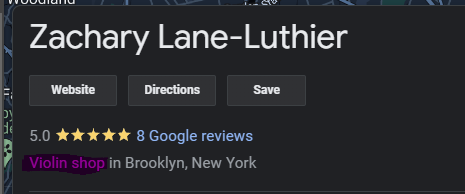

While users could theoretically type any query they want, to test the performance of my Recommender system, I needed easily reproducible queries that readers will be able to validate for themselves. This file with all queries can be found in assets/query_list.xlsx.

In [171]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import urllib.parse
import time

In [155]:
# display list of queries
queries = pd.read_excel(r'assets/query_list.xlsx')
queries.head()

,query
0,Home improvement store
1,Diesel fuel supplier
2,Church
3,Farm
4,Seed supplier


- The below block is commented out because it makes 1000+ requests to Google for the most relevant NAICS code for the query. For example, this sends a request to Google to find "Home improvement store NAICS code," and takes the top returned result to get a baseline most likely NAICS code.
- The results returned from Google do not populate all NAICS codes and sometimes find undesired text/characters.
- I manually updated the remaining ones (there were about 300 or so), with my own judgment on what I believed to be the closest NAICS code. Unfortunately, this is tough to replicate exactly because it comes down to your discretion, but you can always look at the final dataframe to confirm for yourself whether or not you think the NAICS codes are relevant to the query.
- This code will take hours to run, so leave it commented out and skip to where the file is loaded in from asssets/related_naics.csv


In [156]:
# # set user agent so that Google believes the request is comign from a browser
# headers = {
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'
# }

# # Due to Google restricting the use of web scrapers, we need to set a random time delay in between each query so that Google cannot detect the bot
# rng = np.random.default_rng()

# for row in queries.iterrows():
#     query = urllib.parse.quote(str(row[1]['query']) + ' NAICS Code')
#     soup = BeautifulSoup(requests.get(f'https://www.google.com/search?q={query}', headers=headers).text, 'html.parser')
#     if soup.body.find(class_='LC20lb MBeuO DKV0Md') != None:
#         result = soup.body.find(class_='LC20lb MBeuO DKV0Md').text.split(' ')[2]
#         queries.loc[row[0], 'relevant_naics'] = result.replace('\'', '')
#     else:
#         print(f'{queries.loc[row[0], "query"]} : No results found')

#     queries.to_csv('assets/related_naics.csv', index=False)
#     time.sleep(rng.uniform(1,10))

In [157]:
related_naics = pd.read_csv('assets/related_naics.csv')
related_naics.head()

,query,relevant_naics
0,Home improvement store,444110
1,Diesel fuel supplier,424710
2,Church,813110
3,Farm,115116
4,Seed supplier,424910


In [158]:
# load in NAICS codes
naics_titles = pd.read_excel('assets/6-digit_2017_Codes.xlsx')
naics_titles['naics'] = naics_titles['naics'].astype(str)
naics_titles.head()

,naics,title,Unnamed: 2
0,111110,Soybean Farming,NaN
1,111120,Oilseed (except Soybean) Farming,NaN
2,111130,Dry Pea and Bean Farming,NaN
3,111140,Wheat Farming,NaN
4,111150,Corn Farming,NaN


- The below block of code fills in the lists in the relevant_naics columnm, with the next most likely NAICS in descending order.
- This decision was made, because each 6 digit NAICS code falls under a higher-level, lower-digit NAICS code. For example, classess 111110 and 111111 are both unique class code, but they fall under the subclass of all classes that begin with "1111", and "111", and "11", etc.
- First the code will find the closest corresponding 6 digit NAICS codes, and then go further down the line and add on the most relevant 2 digit NAIC code groups.
- This is not a 100% fool proof method, as queries can pertain to NAICS codes that are not within the same group. 
- For example, a user could query "music store", and the might get a result for "451140 - musical instrument store", plus all other codes that begin with 45115, etc. 
- However, this query would exclude something like "339992 - Musical Instrument Manufacturing", because it doesn't even match numbers at the highest level possible (45 and 33 do not match). 
- This is one major drawback of my project. I simply did not have enough resources to create a curated list with all possible relevant NAICS codes, so I stuck with creating a list that contains codes that are industry related. If I had more time and resources, I would go back to this part and try to expand my query / NAICS code relationship further.


You can read more about the breakdown of Sector, Subsector, Industry Group, NAICS Industry, and National Industry code breakdown here: https://www.census.gov/programs-surveys/economic-census/guidance/understanding-naics.html to understand how they are grouped together.

In [159]:
related_naics

,query,relevant_naics
0,Home improvement store,444110
1,Diesel fuel supplier,424710
2,Church,813110
3,Farm,115116
4,Seed supplier,424910
...,...,...
1149,State department agricultural development,926140
1150,Military base,928110
1151,Embassy,928120
1152,Window supplier,321911


In [167]:
def add_relevant_codes(naics_df, query_df):
    query_df = query_df.copy()
    for row in query_df.iterrows():
        rel_codes = []
        
        # add related codes in descending order from highest number of digits to lowest number of digits
        for i in range(6, 1, -1):
            relevant = naics_df[naics_df['naics'].str.slice(start=0, stop=i) == str(row[1]['relevant_naics'])[:i]]['naics']
            for code in relevant:
                if code not in rel_codes:
                    rel_codes.append(code)
        row[1]['relevant_naics'] = rel_codes
        query_df.iloc[row[0]] = row[1]
    return query_df

In [168]:
relevant_naics_df = add_relevant_codes(naics_titles, related_naics)

In [173]:
relevant_naics_df.head()

,query,relevant_naics
0,Home improvement store,"[444110, 444120, 444130, 444190, 444210, 44422..."
1,Diesel fuel supplier,"[424710, 424720, 424110, 424120, 424130, 42421..."
2,Church,"[813110, 813211, 813212, 813219, 813311, 81331..."
3,Farm,"[115116, 115111, 115112, 115113, 115114, 11511..."
4,Seed supplier,"[424910, 424920, 424930, 424940, 424950, 42499..."


In [170]:
relevant_naics_df.to_pickle('assets/relevant_naics_df.pkl')

At the end, we are left with a dataframe that contains all queries, and a list of relevant NAICS codes in descending order.